## <b style="color:Green;">Graph Creation</b>
used to create a graph data structure for the selected nodes

### <b> Importing Libraries </b>

In [425]:
%reset

In [433]:
import pickle
import pandas as pd
import torch
import networkx as nx

In [427]:
user_data=pd.read_csv("data/musae_git_target.csv")
selected_nodes=pickle.load(open("data/selected_nodes.pkl","rb"))
edge_data=pd.read_csv("data/musae_git_edges.csv")

In [428]:
selected_nodes.drop(["index"],axis=1,inplace=True)

In [429]:
selected_nodes["id"]=selected_nodes["id"].astype("int")

In [430]:
selected_nodes["ml_target"]=selected_nodes["id"].apply(lambda idx : user_data.iloc[idx]["ml_target"])

In [431]:
selected_nodes.loc[selected_nodes["id"]==33262]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,id,ml_target
29159,2589,1515,3214,1953,3129,3077,364,1171,1022,2045,536,1563,2449,1532,3771,33262,0


### <b> Graph Gen Logic 1 </b>

* lets take 1000 developers , that is 1000 graphs with 10 nodes 
* logic : Get the first level of connection for a node if not suffient no. of nodes acquired then go for the second level
* then we'll train the network based on it

<b> Update Needed : select only the nodes which is from the selected_nodes ,i.e nodes which with >= 15 features </b> <br>
    update done in next cell

[[33262, 35251, 35251, 30809, 30809, 30809, 30809, 30809, 30809], [35251, 30809, 37690, 18335, 31248, 36628, 15940, 36834, 37438]]
10
Developer's Name : forivall


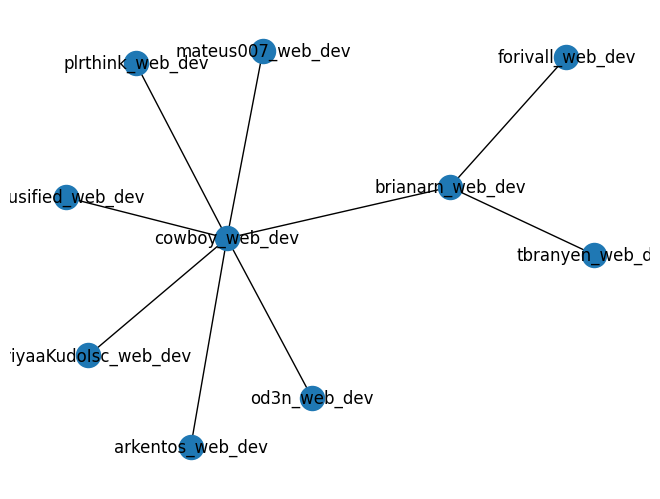

In [434]:
edge_index=[[],[]]
nodes_parsed=[]
def generate_graph(dev_id,nodes_needed):
    neighbour_dev_ids=edge_data.loc[edge_data["id_1"]==dev_id]["id_2"].values
    for neighbour_dev in neighbour_dev_ids:
        if len(set([item for sublist in edge_index for item in sublist]))>=10:
            break
        else:
            edge_index[0].append(dev_id),edge_index[1].append(neighbour_dev)
    nodes_parsed.append(dev_id)
    nodes=set([item for sublist in edge_index for item in sublist])
    if len(nodes)>=nodes_needed:
        return edge_index
    else:
        dev_id = list(set(nodes) - set(nodes_parsed))[0]
        nodes_needed-=len(neighbour_dev_ids)+1 #why plus 1 because of the current node 
        return generate_graph(dev_id,nodes_needed)

dev_id=int(input("Enter Dev Id : "))


result=generate_graph(dev_id,10)
print(result)
nodes=set([item for sublist in result for item in sublist])
print(len(nodes))



### Visualization

dev_name=user_data.loc[user_data["id"]==dev_id]["name"].values[0]
print("Developer's Name :",dev_name)
Graph=nx.Graph()
for source,dest in zip(result[0],result[1]):
    src_name,dest_name=user_data.loc[user_data["id"]==source]["name"].values[0],user_data.loc[user_data["id"]==dest]["name"].values[0]
    src_domain,dest_domain=user_data.loc[user_data["id"]==source]["ml_target"].values[0],user_data.loc[user_data["id"]==dest]["ml_target"].values[0]
    if src_domain==1:
        src_domain="ML_dev"
    else:
        src_domain="web_dev"
    if dest_domain==1:
        dest_domain="ML_dev"
    else:
        dest_domain="web_dev"
    src,dest=src_name+"_"+src_domain,dest_name+"_"+dest_domain
    Graph.add_edge(src,dest)
nx.draw(Graph,with_labels=True)

## <b> Graph creation update done
* selecting only the nodes which has a feature size of more than 15
* previously we had considering the the friendship between two devs only if there is a connection from id1 to id2 
* but from the document it is clear that it is not the directed from id1 to id2  the vice verse is also considered as a valid connection


[[123, 6724, 6724, 6724, 6724, 3185, 3185, 3185, 3185, 3185, 3185], [6724, 3185, 123, 35773, 15686, 6724, 17580, 22782, 11854, 11038, 27803]]
10
Developer's Name : quraisahamid


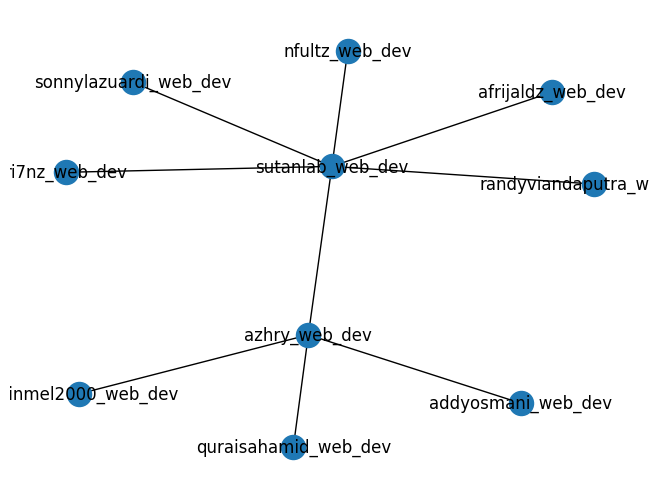

In [453]:
selected_nodes_ids=list(selected_nodes["id"])
edge_index=[[],[]]
nodes_parsed=[]
def generate_graph(dev_id,nodes_needed):

    neighbour_dev_ids=list(edge_data.loc[edge_data["id_1"]==dev_id]["id_2"].values)+list(edge_data.loc[edge_data["id_2"]==dev_id]["id_1"].values)
    neighbour_dev_ids=list(set(neighbour_dev_ids))
    still_needed=0
    for neighbour_dev in neighbour_dev_ids:
        if len(set([item for sublist in edge_index for item in sublist]))>=10:
            break
        else:
            if dev_id in selected_nodes_ids and neighbour_dev in selected_nodes_ids:
                edge_index[0].append(dev_id),edge_index[1].append(neighbour_dev)
                still_needed+=1
            else:
                pass
                
    nodes_parsed.append(dev_id)
    nodes=set([item for sublist in edge_index for item in sublist])
    if len(nodes)>=nodes_needed:
        return edge_index
    else:
        dev_id = list(set(nodes) - set(nodes_parsed))[0]
        nodes_needed-=still_needed+1 #why plus 1 because of the current node 
        return generate_graph(dev_id,nodes_needed)



dev_id=int(input("Enter Dev Id : "))


result=generate_graph(dev_id,10)
print(result)
nodes=set([item for sublist in result for item in sublist])
print(len(nodes))



### Visualization

dev_name=user_data.loc[user_data["id"]==dev_id]["name"].values[0]
print("Developer's Name :",dev_name)
Graph=nx.Graph()
for source,dest in zip(result[0],result[1]):
    src_name,dest_name=user_data.loc[user_data["id"]==source]["name"].values[0],user_data.loc[user_data["id"]==dest]["name"].values[0]
    src_domain,dest_domain=user_data.loc[user_data["id"]==source]["ml_target"].values[0],user_data.loc[user_data["id"]==dest]["ml_target"].values[0]
    if src_domain==1:
        src_domain="ML_dev"
    else:
        src_domain="web_dev"
    if dest_domain==1:
        dest_domain="ML_dev"
    else:
        dest_domain="web_dev"
    src,dest=src_name+"_"+src_domain,dest_name+"_"+dest_domain
    Graph.add_edge(src,dest)
nx.draw(Graph,with_labels=True)


### <b> Making a dataset </b>

lets take 700 ML devs and 700 web devs and make a graph structures for them

In [375]:
web_samples = selected_nodes[selected_nodes['ml_target'] == 0].sample(700, random_state=42)
ml_samples = selected_nodes[selected_nodes['ml_target'] == 1].sample(700, random_state=42)
train_samples=pd.concat([web_samples,ml_samples],axis=0)

In [399]:
for sample in train_samples.iterrows():
    dev_id=sample[1]["id"]
    edge_idx=generate_graph(dev_id,10)
    nodes=set([ele for sublist in edge_idx for ele in sublist])
    mappings=dict(enumerate(nodes))
    print(edge_idx,"\n",mappings,"\n",len(mappings))
    #replace edge_idx with mapped number and put values data.x according
    
    break

[[33262, 35251, 35251, 30809, 30809, 30809, 30809, 30809, 30809], [35251, 30809, 37690, 18335, 31248, 36628, 15940, 36834, 37438]] 
 {0: 36834, 1: 15940, 2: 33262, 3: 31248, 4: 35251, 5: 36628, 6: 30809, 7: 37690, 8: 37438, 9: 18335} 
 10


In [396]:
selected_nodes.loc[selected_nodes["id"]==8365]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,id,ml_target


In [397]:
dev_id

33262

In [400]:
data_x=[]
for map,idx in mappings.items():
    if len(list(selected_nodes.loc[selected_nodes["id"]==idx][list(range(15))].values))==0:
        print(idx,map)
    data_x.append(list(selected_nodes.loc[selected_nodes["id"]==idx][list(range(15))].values))
    
print(data_x)
# data_x=torch.Tensor(data_x)
# data_x.shape

37690 7
37438 8
[[array([3272, 1500, 3214, 2717, 3129, 1852, 3077,  364, 1171, 1022, 2045,
        536, 2565, 3105, 1532], dtype=int64)], [array([3132, 1727, 3214,  476, 1852, 3077, 1171, 3763, 2045,  536, 1181,
       1764, 2289, 1532, 3771], dtype=int64)], [array([2589, 1515, 3214, 1953, 3129, 3077,  364, 1171, 1022, 2045,  536,
       1563, 2449, 1532, 3771], dtype=int64)], [array([1000, 1500, 3214, 2914, 3129, 1852, 1171, 1022, 2045,  536, 3479,
       1532, 3771, 3293,   35], dtype=int64)], [array([2048, 1848, 3214, 2665, 1852, 3077,  364, 1171, 3763, 2045, 3582,
       1532, 2472, 3794, 3978], dtype=int64)], [array([ 493, 3937, 3214, 2588, 3129, 3077, 1171, 1022, 2045,  536, 3447,
       3771,  650,  317, 2651], dtype=int64)], [array([ 349, 2437, 3214, 2464, 3077,  364, 3763, 2045,  536, 3558, 3074,
       2472,  673,  664, 2076], dtype=int64)], [], [], [array([2048,  333,  925, 3278, 3129, 3077, 1171, 3763,  536, 2337, 1532,
       2472,  234, 1820,  247], dtype=int64)]]


In [265]:
edge_idx,mappings
mapping_inverse={value:key for key,value in mappings.items()}

print(edge_idx,"\n",mapping_inverse)

for i in range(len(edge_idx)):
    for j in range(len(edge_idx[i])):
        edge_idx[i][j]=mapping_inverse[edge_idx[i][j]]

print(edge_idx)



[[15, 15, 15, 15, 15, 15, 15, 15, 15], [10219, 17787, 3368, 19253, 12921, 30002, 5310, 9049, 30833]] 
 {3368: 0, 10219: 1, 15: 2, 30833: 3, 30002: 4, 19253: 5, 9049: 6, 12921: 7, 17787: 8, 5310: 9}
[[2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 8, 0, 5, 7, 4, 9, 6, 3]]


In [256]:
edge_idx[0][3]
print(j)
mapping_inverse[edge_idx[j]]

0


TypeError: unhashable type: 'list'

In [40]:
import torch
from torch_geometric.data import Data, DataLoader

# Define a simple PyTorch Geometric dataset with 4 graphs, each having 3 nodes
graph1 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([0, 1, 0]))
# in  our case the x will be 10 rows and 15 columns
graph2 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([1, 0, 1]))
graph3 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([0, 1, 1]))
graph4 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([1, 0, 0]))

# Create a list of graphs to form the dataset
dataset = [graph1, graph2, graph3, graph4]

# Create a PyTorch Geometric DataLoader
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Iterate over batches
for batch in loader:
    print("Batch:")
    print("Number of graphs in the batch:", batch.num_graphs)
    print("Node features shape:", batch.x.shape)
    print("Edge indices shape:", batch.edge_index.shape)
    print("Node labels shape:", batch.y.shape)
    print()


[21351, 24444, 15808, 13411, 13893]